# YOLOv3 for Flickr Logos 27 dataset from torchvision

### Minimum Requirements:
- Train a PyTorch model to detect logos.
- Implement IoU metrics and augmentation techniques.

### Extra Points (Optional):
- Implement test-time augmentation.
- Explore additional metric learning methods to improve class differentiation.
- Emphasize quality code and abstract thinking.


## Import packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader
import config
from utils import fix_seed, check_class_accuracy, \
    cells_to_bboxes, non_max_suppression, plot_image, YOLODataset

## Build YOLOv3 architecture

**Darknet-53 architecture**   
<center>

![Alt text](image/darknet_53_table.png "a title")
</center>

The elements of the `CONFIG` include tuples, lists, and strings, which correspond to different types of layers.  

**Tuple** is structured by and signifies a convolutional block (out_channels, kernel_size, stride)  
**List** is structured by and signifies a residual block ["Residual"/`ResidualBlock()`, number_of_repeat]  
**"Residual"** indicating a residual block followed by the number of repeats  
**"Scale"** is for a scale prediction block and computing the yolo loss  
**"Upsample"** is for upsampling the feature map

In [2]:
CONFIG = [
    (32, 3, 1),
    (64, 3, 2),
    ["Residual", 1],
    (128, 3, 2),
    ["Residual", 2],
    (256, 3, 2),
    ["Residual", 8],
    # first route from the end of the previous block
    (512, 3, 2),
    ["Residual", 8], 
    # second route from the end of the previous block
    (1024, 3, 2),
    ["Residual", 4],
    # until here is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "Scale",
    (256, 1, 1),
    "Upsample",
    (256, 1, 1),
    (512, 3, 1),
    "Scale",
    (128, 1, 1),
    "Upsample",
    (128, 1, 1),
    (256, 3, 1),
    "Scale",
]

With the help of the diagram, we can have a better understanding of the relationship between the architecture of YOLOv3 and its `CONFIG`, and we can also have a clearer idea of when to use the classes provided by us.
<center>

![Alt text](image/yolov3_custom.jpg "a title")
</center>

The following three classes correspond to the three subregions as shown in the YOLOv3 architecture diagram (red).  

1. The `CNNBlock()`: corresponds to the DBL in the diagram, and through the parameter bn_act, we can control whether to add Batch Normalization and Leaky ReLU after the convolutional layer.  

2. The `ResidualBlock()` corresponds to the res unit in the diagram, and through the parameter use_residual, we can control whether to add the residual connection. Also, we can control the number of repeats of the res unit.  

3. The `ScalePrediction()` corresponds to the subregion before output in the diagram, and through the parameter num_classes, we can determine the number of classes to be predicted.  

In [3]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act
        
    def forward(self, x):
        if self.use_bn_act:
            return self.leaky_relu(self.bn(self.conv(x)))
        else:
            return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]
        self.use_residual = use_residual
        self.num_repeats = num_repeats
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x) + x if self.use_residual else layer(x)
        
        return x
    
class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2 * in_channels, kernel_size=3, padding=1),
            CNNBlock(2 * in_channels, (num_classes + 5) * 3, bn_act=False, kernel_size=1)
        )
        self.num_classes = num_classes
        
    def forward(self, x):
        return (
            self.pred(x)
            .reshape(x.shape[0], 3, self.num_classes + 5, x.shape[2], x.shape[3])
            .permute(0, 1, 3, 4, 2)
        )   # output shape: (batch_size, 3, grid_size, grid_size, num_classes + 5)
        

Using the three sub-modules mentioned above, we can build the YOLOv3 architecture according to the `CONFIG`.  

In [4]:
class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=80):
        super(YOLOv3, self).__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels
        
        for module in CONFIG:        
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                in_channels = out_channels

            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(
                    ResidualBlock(
                        in_channels,
                        num_repeats=num_repeats,
                    )
                )
            
            elif isinstance(module, str):
                if module == "Scale":
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                        ScalePrediction(in_channels // 2, num_classes=self.num_classes),
                    ]
                    in_channels = in_channels // 2

                elif module == "Upsample":
                    layers.append(
                        nn.Upsample(scale_factor=2),
                    )
                    in_channels = in_channels * 3
                    
        return layers
    
    def forward(self, x):
        outputs = []
        route_connections = []  # for skip connections
        
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                # pass
                outputs.append(layer(x))
                continue
            
            x = layer(x) # pass the input through the layer
            
            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)   

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()
        return outputs

Then we can run a test to know if model has been built up correctly.

In [5]:
def test():
    num_classes = 20
    model = YOLOv3(num_classes=num_classes)
    img_size = 416
    x = torch.randn((2, 3, img_size, img_size))
    out = model(x)
    print("shape of feature_map_1:", out[0].shape)
    print("shape of feature_map_2:", out[1].shape)
    print("shape of feature_map_3:", out[2].shape)
    assert out[0].shape == (2, 3, img_size//32, img_size//32, 5 + num_classes), "shape of feature_map_1 is wrong"
    assert out[1].shape == (2, 3, img_size//16, img_size//16, 5 + num_classes), "shape of feature_map_2 is wrong"
    assert out[2].shape == (2, 3, img_size//8, img_size//8, 5 + num_classes), "shape of feature_map_3 is wrong"
    print("Success!")

test()

shape of feature_map_1: torch.Size([2, 3, 13, 13, 25])
shape of feature_map_2: torch.Size([2, 3, 26, 26, 25])
shape of feature_map_3: torch.Size([2, 3, 52, 52, 25])
Success!


## Implement the YOLO loss
### Before calculating the loss, we need to first calculate the IoU.  
When evaluating the performance of object detection and segmentation models, Intersection over Union (IoU) is a commonly used metric.  
IoU measures the ratio of the overlap between the predicted and ground-truth objects, with the formula:
$$
IoU = \frac{intersection\; area}{union\; area + 10^{-6}}
$$
Among, $10^{-6}$ is used to avoid calculation error.  

It's more clear to see the graph below.  
<center>

![Alt text](image/iou.jpeg "a title")
</center>

In [6]:
def iou(boxes_preds, boxes_labels):
    """
    :param boxes_preds (tensor): shape (num_of_preds, 4), where 4 is (x, y, w, h)
    :param boxes_labels (tensor): shape (num_of_labels, 4), where 4 is (x, y, w, h)
    """ 
    
    box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
    box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
    box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
    box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    iou = intersection / (box1_area + box2_area - intersection + 1e-6)
    
    return iou.detach()

In [7]:
from utils import intersection_over_union

def test():
    box1_1 = torch.tensor([[0.5, 0.5, 0.5, 0.5]])
    box1_2 = torch.tensor([[0.75, 0.75, 0.5, 0.5]])
    box2_1 = torch.tensor([[0, 0, 0, 0], [1, 1, 1, 1]])
    box2_2 = torch.tensor([[0, 0, 0, 0], [1, 1, 1, 1]])
    
    test1_1 = torch.round(iou(box1_1, box1_2)*10000) / 10000
    test1_2 = torch.round(intersection_over_union(box1_1, box1_2)* 10000) / 10000
    test2_1 = torch.round(iou(box2_1, box2_2)*10000) / 10000
    test2_2 = torch.round(intersection_over_union(box2_1, box2_2)* 10000) / 10000
    
    assert test1_1 == test1_2, "calculation of iou is wrong"
    assert test2_1.shape == test2_2.shape, "shape of iou is wrong"
    assert test2_1[0] == test2_2[0], "be careful of the case when there is nan in the iou"
    print("Suceess!")
    
test()

Suceess!


### Then we can move on the loss calculation.  

First we will form two binary tensors signifying where in what cells using which anchors that have objects assigned to them and not. 
```python      
obj = target[..., 0] == 1 
noobj = target[..., 0] == 0 
```
The reason for not only using one of these is that we in the data loading assign the anchors which we should ignore to -1. 

### 1. No object loss
For the anchors in all cells that do not have an object assigned to them i.e. all indices that are set to one in `noobj` we want to incur loss only for their object score. The target will be all zeros since we want these anchors to predict an object score of zero and we will apply a sigmoid function to the network outputs and use a binary crossentropy loss. 

In mathematics we have that 
$$
\begin{aligned} 
L_{noobj} &= \frac{1}{N \sum_{a, i,j} \mathbb{1}_{a\ i\ j}^{\text {noobj }}} \sum_{n=1}^N \sum_{a,i,j \in \mathbb{1}_{a\ i \ j}^{\text {noobj }}} BCE \left ( y_{n,a,i,j}^{obj}, \sigma\left(t_{n,a,i,j}^{obj}\right)\right) \\
&=\frac{1}{N \sum_{a, i,j} \mathbb{1}_{a\ i\ j}^{\text {noobj }}} \sum_{n=1}^N \sum_{a,i,j \in \mathbb{1}_{a\ i \ j}^{\text {noobj }}} -\left[y_{n,a,i,j}^{obj} \cdot \log \sigma\left(t_{n,a,i,j}^{obj}\right)+\left(1-y_{n,a,i,j}^{obj}\right) \cdot \log \left(1-\sigma(t_{n,a,i,j}^{obj})\right)\right]
\end{aligned}
$$

where $N$ is the batch size, $i,\ j$ signifies the cell where and $a$ the anchor index and $\mathbb{1}_{a\ i\ j}^{\text {noobj }}$ is a binary tensor with ones on anchors not assigned to an object. The output from the network is denoted $t$ and the target $y$ and $\sigma$ is the sigmoid function given by 

$$
\sigma(x) = \frac{1}{1+e^{-x}}.
$$

### 2. Object loss

In the code we will convert the model predictions to bounding boxes according to the formulas in the paper
$$
\begin{array}{l}
b_{x}=\sigma\left(t_{x}\right) \\
b_{y}=\sigma\left(t_{y}\right) \\
b_{w}=p_{w} e^{t_{w}} \\
b_{h}=p_{h} e^{t_{h}},
\end{array} \\
$$
where $p_w$ and $p_h$ are the anchor box dimensions and ($b_x, b_y, b_w, b_h$) is the resulting bounding box relative to the cell. We will then calculate the intersection over union with the target that we defined in the dataset class and lastly as in the no object loss above apply the binary cross entropy loss between the object score predictions and the calculated intersection over union. Note that the loss will only be applied to the anchors assigned to a target bounding box signified by indexing by `obj`.  

The mathematical formula will be similar to the one above 
$$
L_{obj}= \frac{1}{N \sum_{a, i,j} \mathbb{1}_{a\ i\ j}^{\text {obj }}} \sum_{n=1}^N \sum_{a,i,j \in \mathbb{1}_{a\ i \ j}^{\text {obj }}} BCE \left ( \hat{y}_{n,a,i,j}^{obj}, \sigma\left(t_{n,a,i,j}^{obj}\right)\right)
$$
with 
$$ \hat{y} = IOU(y^{box}, b) $$
where $b$ is the bounding box computed above and $ \mathbb{1}_{a\ i\ j}^{\text {obj }}$ corresponds to the binary tensor with ones for the anchors assigned to a target bounding box. 

### 3. Box coordinates loss
For the box coordinates we will simply use a mean squared error loss in the positions where there actually are objects. All predictions where there is no corresponding target bounding box will be ignored. We will apply a sigmoid function to the $x$
and $y$ coordinates to make sure that they are between \[0,1\] but instead of converting the widths and heights as above we want to compute the ground truth value $\hat{t}$ that the network should predict. We find it by inverting the formula above for the bounding boxes
$$ 
\begin{aligned}
\hat{t}_w &= \log (y_w / p_w) \\
\hat{t}_h &= \log (y_h / p_h)
\end{aligned}
$$
where the $y_w$ and $y_h$ are the target width and height. We will then apply the mean squared error loss between the targets and predictions.  

The formula is given by
$$
L_{box} = \frac{1}{N \sum_{a, i,j} \mathbb{1}_{a\ i\ j}^{\text {obj }}} \sum_{n=1}^N \sum_{a,i,j \in \mathbb{1}_{a\ i \ j}^{\text {obj }}}  \left(\sigma(t^x_{n,a,i,j}) - y^x_{n,a,i,j} \right)^2 +
\left(\sigma(t^y_{n,a,i,j}) - y^y_{n,a,i,j} \right)^2 +
\left(t^w_{n,a,i,j} - \hat{t}^w_{n,a,i,j} \right)^2 +
\left(t^h_{n,a,i,j} - \hat{t}^h_{n,a,i,j} \right)^2, 
$$
where $\hat{t}^*$ is the ground truth labels for what actual values the model should predict.

### 4. Class loss
We will only incur loss for the class predictions where there actually is an object. Our implementation differs slightly from the paper's in the case of a class loss and we will use a cross entropy loss to compute the class loss. This assumes that each bounding box only has one label. The YOLOv3 motivates that it does not want to have this limitation and instead uses an binary cross entropy such that several labels can be assigned to a single object e.g. woman and person. 

The formula is given by
$$ 
L_{class} = \frac{1}{N \sum_{a, i,j} \mathbb{1}_{a\ i\ j}^{\text {obj }}} \sum_{n=1}^N \sum_{a,i,j \in \mathbb{1}_{a\ i \ j}^{\text {obj }}} -\log \left(\frac{\exp (t_{n, a, i,j}^{c})}{\sum_{k} \exp (t_{n, a, i,j}^k)}\right),
$$
where $t_{n, a, i,j}^{c}$ is the prediction for the correct class $c$. 

### **Total loss**
$$ L= \lambda_{noobj} L_{noobj} + \lambda_{obj} L_{obj} + \lambda_{box} L_{box} + \lambda_{class} L_{class} $$


In [8]:
class YoloLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()

        # Constants signifying how much to pay for each respective part of the loss
        self.lambda_class = 1
        self.lambda_noobj = 1
        self.lambda_obj = 10
        self.lambda_box = 10

    def forward(self, predictions, target, anchors):
        """
        :param predictions: output from model of shape: (batch size, anchors on scale , grid size, grid size, 5 + num classes)
        :param target: targets on particular scale of shape: (batch size, anchors on scale, grid size, grid size, 6)
        :param anchors: anchor boxes on the particular scale of shape (anchors on scale, 2)
        :return: returns the loss on the particular scale
        """

        # Check where obj and noobj (we ignore if target == -1)
        # Here we check where in the label matrix there is an object or not
        obj = target[..., 0] == 1  # in paper this is Iobj_i
        noobj = target[..., 0] == 0  # in paper this is Inoobj_i
        
        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #
        # The indexing noobj refers to the fact that we only apply the loss where there is no object
        no_object_loss = self.bce(
            (predictions[..., 0:1][noobj]), (target[..., 0:1][noobj]),
        )


        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #
        # Here we compute the loss for the cells and anchor boxes that contain an object
        # Reshape anchors to allow for broadcasting in multiplication below
        anchors = anchors.reshape(1, 3, 1, 1, 2)
        
        box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        ious = iou(box_preds[obj], target[..., 1:5][obj])
        
        # Only incur loss for the cells where there is an objects signified by indexing with obj
        object_loss = self.bce((predictions[..., 0:1][obj]), (ious * target[..., 0:1][obj]))
        
        
        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #
        # apply sigmoid to x, y coordinates to convert to bounding boxes
        predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3]) 
        # to improve gradient flow we convert targets' width and height to the same format as predictions
        target[..., 3:5] = torch.log(
            (1e-16 + target[..., 3:5] / anchors)
        ) 
        # compute mse loss for boxes
        box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])


        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #
        # here we just apply cross entropy loss as is customary with classification problems
        class_loss = self.entropy(
            (predictions[..., 5:][obj]), (target[..., 5][obj].long()),
        )
        
        # ================== #
        #     TOTAL LOSS     #
        # ================== #
        total_loss = self.lambda_box * box_loss \
            + self.lambda_obj * object_loss \
            + self.lambda_noobj * no_object_loss \
            + self.lambda_class * class_loss
        
        return total_loss

## Build train function and load data

### Create train function

In [9]:
# torch.backends.cudnn.benchmark = True
def train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors):
    loop = tqdm(train_loader, leave=True)
    losses = []
    for batch_idx, (x, y) in enumerate(loop):
        x = x.to(config.DEVICE)
        y0, y1, y2 = (
            y[0].to(config.DEVICE),
            y[1].to(config.DEVICE),
            y[2].to(config.DEVICE),
        )

        with torch.cuda.amp.autocast():
            out = model(x)
            loss = (
                loss_fn(out[0], y0, scaled_anchors[0])
                + loss_fn(out[1], y1, scaled_anchors[1])
                + loss_fn(out[2], y2, scaled_anchors[2])
            )
            
        losses.append(loss.item())
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update progress bar
        mean_loss = sum(losses) / len(losses)
        loop.set_postfix(loss=mean_loss)

### Create Flickr Logos 27 dataset loading function

In [10]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import numpy as np
import os

def iou_width_height(boxes1, boxes2):
    """
    Parameters:
        boxes1 (tensor): width and height of the first bounding boxes
        boxes2 (tensor): width and height of the second bounding boxes
    Returns:
        tensor: Intersection over union of the corresponding boxes
    """
    intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * torch.min(
        boxes1[..., 1], boxes2[..., 1]
    )
    union = (
        boxes1[..., 0] * boxes1[..., 1] + boxes2[..., 0] * boxes2[..., 1] - intersection
    )
    return intersection / union

class YOLODataset(Dataset):
    def __init__(
        self,
        csv_file,
        img_dir, label_dir,
        anchors,
        image_size=416, # default image size
        S=[13, 26, 52], # default grid size
        C=20,           # default number of classes
        transform=None,
    ):
        super().__init__()
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])   # each scale has 3 anchors
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.C = C
        self.ignore_iou_thresh = 0.5
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist()
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = np.array(Image.open(img_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=image, bboxes=bboxes)
            image = augmentations["image"]
            bboxes = augmentations["bboxes"]

        # Below assumes 3 scale predictions (as paper) and same num of anchors per scale
        targets = [torch.zeros((self.num_anchors // 3, S, S, 6)) for S in self.S]
        for box in bboxes:
            iou_anchors = iou_width_height(torch.tensor(box[2:4]), self.anchors)
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x, y, width, height, class_label = box
            has_anchor = [False] * 3  # each scale should have one anchor
            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale
                S = self.S[scale_idx]
                i, j = int(S * y), int(S * x)  # which cell
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]
                if not anchor_taken and not has_anchor[scale_idx]:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                    x_cell, y_cell = S * x - j, S * y - i  # both between [0,1]
                    width_cell, height_cell = (
                        width * S,
                        height * S,
                    )  # can be greater than 1 since it's relative to cell
                    box_coordinates = torch.tensor(
                        [x_cell, y_cell, width_cell, height_cell]
                    )
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True

                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1  # ignore prediction

        return image, tuple(targets)

In [11]:
train_csv_path = config.DATASET + "/pedestrain_film.csv"
test_csv_path = config.DATASET + "/pedestrain_film_test.csv"

IMAGE_SIZE = config.IMAGE_SIZE

train_dataset = YOLODataset(
    train_csv_path,
    transform=config.train_transforms,
    S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
    img_dir=config.IMG_DIR,
    label_dir=config.LABEL_DIR,
    anchors=config.ANCHORS,
)
test_dataset = YOLODataset(
    test_csv_path,
    transform=config.test_transforms,
    S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
    img_dir=config.IMG_DIR,
    label_dir=config.LABEL_DIR,
    anchors=config.ANCHORS,
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=config.BATCH_SIZE,
    num_workers=config.NUM_WORKERS,
    pin_memory=config.PIN_MEMORY,
    shuffle=True,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=config.BATCH_SIZE,
    num_workers=config.NUM_WORKERS,
    pin_memory=config.PIN_MEMORY,
    shuffle=False,
    drop_last=False,
)

Show some samples

c:\Users\jrimm\Documents\tue\assignment-dl-detection-new\utils.py:495: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  scale_idx = anchor_idx // self.num_anchors_per_scale


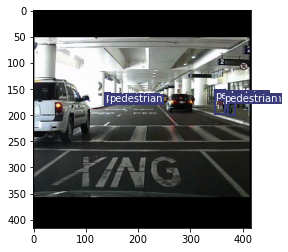

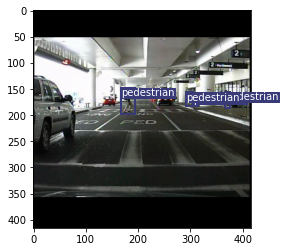

In [12]:
def show_sample():
    anchors = config.ANCHORS

    transform = config.test_transforms

    dataset = YOLODataset(
        "PEDESTRIAN/pedestrain_2_sample.csv",
        "PEDESTRIAN/images/",
        "PEDESTRIAN/labels/",
        S=[13, 26, 52],
        anchors=anchors,
        transform=transform,
        C=1,
    )
    S = [13, 26, 52]
    scaled_anchors = torch.tensor(anchors) / (
        1 / torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    )
    loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
    for x, y in loader:
        boxes = []

        for i in range(y[0].shape[1]):
            anchor = scaled_anchors[i]
            # print(anchor.shape)
            # print(y[i].shape)
            boxes += cells_to_bboxes(
                y[i], is_preds=False, S=y[i].shape[2], anchors=anchor
            )[0]
        boxes = non_max_suppression(boxes, iou_threshold=1, threshold=0.7, box_format="midpoint")
        # print
        plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)
        
show_sample()

In [13]:
# This stops 'Run all' at this cell by causing an error before training
assert False

AssertionError: 

### Train YOLOv3 model

In [ ]:
# DO NOT MODIFY THIS CELL

# Fix random seed for reproducibility
fix_seed(seed=config.SEED)

# Initialize model, optimizer, loss function and scaler
model = YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
)
loss_fn = YoloLoss()
scaler = torch.cuda.amp.GradScaler()

# Scale anchors to each prediction scale
scaled_anchors = (torch.tensor(config.ANCHORS)*torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)).to(config.DEVICE)

print(config.DEVICE)

In [ ]:
# DO NOT MODIFY THIS CELL

for epoch in range(config.NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)
    
    if (epoch+1) % 10 == 0 and epoch > 0:
        print("On Test loader:")
        check_class_accuracy(model, test_loader, threshold=config.CONF_THRESHOLD)

## Exercise 3: Tranfer learning
Transfer Learning is the process of using knowledge and experience learned from one task to accelerate learning in another task. This can be achieved by leveraging pre-trained models, features, and weights from a previous task to reduce the amount of required data and time needed to train a new model for a different task. By doing this, the model's generalization ability and performance can be improved.  

In [14]:
# DO NOT MODIFY THIS CELL

# Fix random seed for reproducibility
fix_seed(seed=config.SEED)

# Initialize model, optimizer, loss function and scaler
model = YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
)
loss_fn = YoloLoss()
scaler = torch.cuda.amp.GradScaler()

# Scale anchors to each prediction scale
scaled_anchors = (torch.tensor(config.ANCHORS)*torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)).to(config.DEVICE)

print(config.DEVICE)

cuda


Try to use `torch.load()` to load the checkpoint file. Please utilize the item `"state_dict"` in checkpoint file to load pre-trained weight.  
Reference: <https://pytorch.org/tutorials/beginner/saving_loading_models.html>

In [15]:
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    
    # BEGIN your code here <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    checkpoint = torch.load(checkpoint_file, map_location=config.DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    # END <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

load_checkpoint("78.1map_0.2threshold_PASCAL.tar", model, optimizer, config.LEARNING_RATE)

=> Loading checkpoint


The accuracy is low now but that is normal. This pre-trained weight is for PASCAL dataset. However, what we want here is the feature extraction ability from our previous training : )

In [16]:
check_class_accuracy(model, test_loader, threshold=config.CONF_THRESHOLD)

100%|██████████| 2/2 [00:02<00:00,  1.35s/it]

Class accuracy is: 16.771488%
No obj accuracy is: 99.572983%
Obj accuracy is: 27.253670%


Try to use `torch.save()` to save the trained weight into the checkpoint file.  
Reference: <https://pytorch.org/tutorials/beginner/saving_loading_models.html>

In [17]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    
    # BEGIN your code here <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    checkpoint = {
        "state_dict": model.state_dict(),
    }
    torch.save(checkpoint, filename)
    # END <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

EarlyStopping testing

In [18]:
import numpy as np

def val_fn(val_loader, model, loss_fn, scaled_anchors):
    model.eval()
    loop = tqdm(val_loader ,desc=f'Validation')
    losses = []
    with torch.no_grad():
        for _, (x, y) in enumerate(loop):
            x = x.to(config.DEVICE)
            y0, y1, y2 = (
                y[0].to(config.DEVICE),
                y[1].to(config.DEVICE),
                y[2].to(config.DEVICE),
            )

            with torch.cuda.amp.autocast():
                out = model(x)
                loss = (
                    loss_fn(out[0], y0, scaled_anchors[0])
                    + loss_fn(out[1], y1, scaled_anchors[1])
                    + loss_fn(out[2], y2, scaled_anchors[2])
                )
                
            losses.append(loss.item())

            # update progress bar
            mean_loss = sum(losses) / len(losses)
            loop.set_postfix(loss=mean_loss)
            loop.update(list(x.shape)[0])
            
    return loss.item()

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to. 
                            Default: 'checkpoint.pth'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model, epoch):
        
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, epoch)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, epoch)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, epoch):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving best model ...')
        torch.save({
            'epoch':epoch,
            'model_state_dict':model.state_dict(),
            }, self.path)
        self.val_loss_min = val_loss

It is high now!!! This is like taking the advantage from previous experience and fit on our current task : )  
We train same 10 epoch. However, this time converge much faster and perform better : )

In [19]:
# DO NOT MODIFY THIS CELL
early_stopping = EarlyStopping(patience=1, verbose=True)    # Initialize the early_stopping object outside the loop

for epoch in range(config.NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)
    val_loss = val_fn(test_loader, model, loss_fn, scaled_anchors)

    early_stopping(val_loss, model, epoch)

    if (epoch+1) % 10 == 0 and epoch > 0:
        print("On Test loader:")
        check_class_accuracy(model, test_loader, threshold=config.CONF_THRESHOLD)
    
    if epoch+1 == config.NUM_EPOCHS:
        save_checkpoint(model, optimizer, filename=f"my_checkpoint_student.pth.tar")
        
    if early_stopping.early_stop:
        print("Early stop at ",epoch,"epoch.")
        break

Validation: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s, loss=25.2]


Validation loss decreased (inf --> 25.279404).  Saving best model ...


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s, loss=21.5]


Validation loss decreased (25.279404 --> 20.718838).  Saving best model ...


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.87it/s, loss=20.4]


Validation loss decreased (20.718838 --> 19.911188).  Saving best model ...


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s, loss=19.8]


Validation loss decreased (19.911188 --> 19.599941).  Saving best model ...


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.66it/s, loss=19.4]


Validation loss decreased (19.599941 --> 19.283033).  Saving best model ...


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.66it/s, loss=19]


Validation loss decreased (19.283033 --> 19.006765).  Saving best model ...


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.60it/s, loss=18.8]


Validation loss decreased (19.006765 --> 18.800213).  Saving best model ...


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.48it/s, loss=18.7]


Validation loss decreased (18.800213 --> 18.625561).  Saving best model ...


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.56it/s, loss=18.4]


Validation loss decreased (18.625561 --> 18.447903).  Saving best model ...


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.51it/s, loss=18.3]


Validation loss decreased (18.447903 --> 18.240108).  Saving best model ...
On Test loader:


100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


Class accuracy is: 98.742142%
No obj accuracy is: 98.992165%
Obj accuracy is: 83.857437%


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.57it/s, loss=18.6]

EarlyStopping counter: 1 out of 1
Early stop at  10 epoch.
